# TPE Hyperparameter Optimization of CNN - Hyperopt

In this notebook, we will use **TPE driven Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package [Hyperopt](http://hyperopt.github.io/hyperopt/).

The MNIST dataset is availale in [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).


## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up the hyperparameter search shape
- Set up a simple CNN
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [4]:
from hyperopt import hp, tpe, fmin, Trials

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

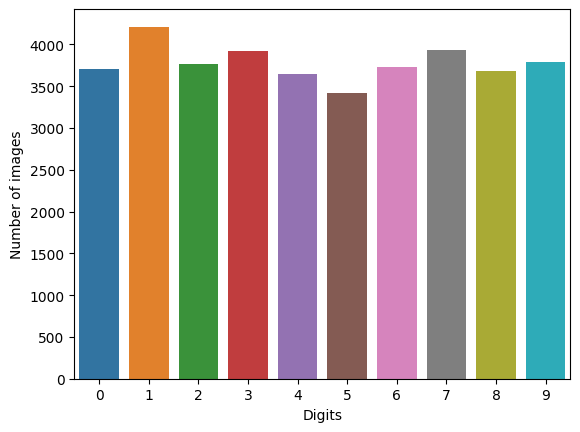

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

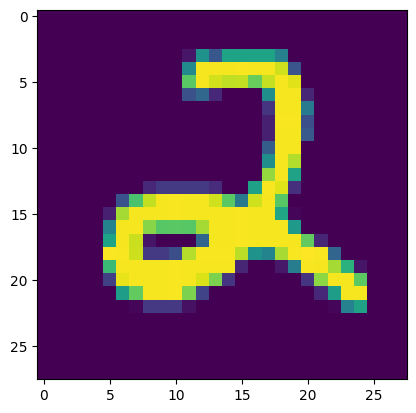

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

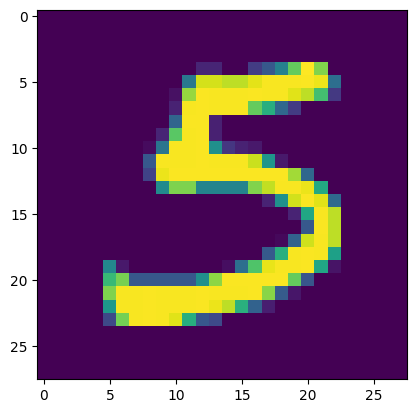

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define the Hyperparameter Space

Hyperopt provides the hp module to create distributions to sample the hyperparameters. More details in [Defining a Search Space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/).


We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of convolutional layers.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [14]:
# determine the hyperparameter space

param_grid = {
    'learning_rate': hp.uniform('learning_rate', 1e-6, 1e-2),
    'num_conv_layers': hp.quniform('num_conv_layers', 1, 3, 1),
    'num_dense_layers': hp.quniform('num_dense_layers', 1, 5, 1),
    'num_dense_nodes': hp.quniform('num_dense_nodes', 5, 512, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
}

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers. Each Convlutional layer, can itself have more than 1 conv layer.

In [15]:
# function to create the CNN

def create_cnn(
    # the hyperparam to optimize are passed
    # as arguments
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function and
    # the number of convolutional layers that it can take.
    
    # We add the different number of conv layers in the following loop:
    
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Objective Function

In [16]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [17]:
def objective(params):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.        
    print('learning rate: ', params['learning_rate'])
    print('num_conv_layers: ', int(params['num_conv_layers']))
    print('num_dense_layers: ',int(params['num_dense_layers']))
    print('num_dense_nodes: ', int(params['num_dense_nodes']))
    print('activation: ', params['activation'])
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=params['learning_rate'],
                       num_conv_layers=int(params['num_conv_layers']),
                       num_dense_layers=int(params['num_dense_layers']),
                       num_dense_nodes=int(params['num_dense_nodes']),
                       activation=params['activation'],
                       )

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [18]:
# Before we run the hyper-parameter optimization,
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = {
    'learning_rate': 1e-5,
    'num_conv_layers': 1,
    'num_dense_layers': 1,
    'num_dense_nodes': 16,
    'activation': 'relu',
}


objective(default_parameters)

learning rate:  1e-05
num_conv_layers:  1
num_dense_layers:  1
num_dense_nodes:  16
activation:  relu



C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 16s 57ms/step - loss: 2.2550 - accuracy: 0.2305 - val_loss: 2.2069 - val_accuracy: 0.3574 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 16s 60ms/step - loss: 2.1454 - accuracy: 0.4382 - val_loss: 2.0715 - val_accuracy: 0.4889 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 16s 59ms/step - loss: 1.9734 - accuracy: 0.5085 - val_loss: 1.8640 - val_accuracy: 0.5169 - lr: 1.0000e-05

Accuracy: 51.69%



-0.5169312357902527

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization with TPE

In [21]:
# fmin performs the minimization
# tpe.suggest samples the parameters following tpe

# with default parameters for TPE
trials = Trials()

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest,  # tpe
    trials=trials
)

learning rate:                                                                                                         
0.006517772255089191                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
418                                                                                                                    
activation:                             

125/266 [=============>................] - ETA: 58s - loss: 2.3389 - accuracy: 0.1094                                  


193/266 [====================>.........] - ETA: 30s - loss: 2.3260 - accuracy: 0.1080                                  


261/266 [============================>.] - ETA: 2s - loss: 2.3198 - accuracy: 0.1057                                  


266/266 [==============================] - 114s 427ms/step - loss: 2.3195 - accuracy: 0.1056 - val_loss: 2.3017 - val_accuracy: 0.1146 - lr: 0.0065

Epoch 2/3                                                                                                              

 61/266 [=====>........................] - ETA: 1:30 - loss: 2.3019 - accuracy: 0.1053                                


129/266 [=============>................] - ETA: 59s - loss: 2.3020 - accuracy: 0.1070                                  


197/266 [=====================>........] - ETA: 28s - loss: 2.3020 - accuracy: 0.1062                                  


265/266 [============================>.] - ETA: 0s - loss: 2.3018 - accuracy: 0.1090                                  


266/266 [==============================] - 110s 415ms/step - loss: 2.3018 - accuracy: 0.1088 - val_loss: 2.3006 - val_accuracy: 0.1146 - lr: 0.0065

Epoch 3/3                                                                                                              

 65/266 [======>.......................] - ETA: 1:15 - loss: 2.3013 - accuracy: 0.1129                                


133/266 [==============>...............] - ETA: 49s - loss: 2.3011 - accuracy: 0.1130                                  


201/266 [=====================>........] - ETA: 24s - loss: 2.3012 - accuracy: 0.1123                                  


266/266 [==============================] - ETA: 0s - loss: 2.3016 - accuracy: 0.1111                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0032588860485702753.

266/266 [==============================] - 101s 380ms/step - loss: 2.3016 - accuracy: 0.1111 - val_loss: 2.3016 - val_accuracy: 0.1146 - lr: 0.0065



Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.000600301954624924                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
157                                     

124/266 [============>.................] - ETA: 51s - loss: 2.3138 - accuracy: 0.1066                                  


192/266 [====================>.........] - ETA: 26s - loss: 2.3106 - accuracy: 0.1059                                  


260/266 [============================>.] - ETA: 2s - loss: 2.3101 - accuracy: 0.1060                                  


266/266 [==============================] - 99s 368ms/step - loss: 2.3100 - accuracy: 0.1060 - val_loss: 2.3041 - val_accuracy: 0.1146 - lr: 6.0030e-04

Epoch 2/3                                                                                                              

 60/266 [=====>........................] - ETA: 1:15 - loss: 2.3076 - accuracy: 0.1026                                


128/266 [=============>................] - ETA: 49s - loss: 2.3077 - accuracy: 0.1003                                  


196/266 [=====================>........] - ETA: 25s - loss: 2.3076 - accuracy: 0.1023                                  


264/266 [============================>.] - ETA: 0s - loss: 2.3071 - accuracy: 0.1046                                  


266/266 [==============================] - 98s 368ms/step - loss: 2.3072 - accuracy: 0.1045 - val_loss: 2.3064 - val_accuracy: 0.0937 - lr: 6.0030e-04

Epoch 3/3                                                                                                              

 64/266 [======>.......................] - ETA: 1:12 - loss: 2.3061 - accuracy: 0.1062                                


132/266 [=============>................] - ETA: 48s - loss: 2.3054 - accuracy: 0.1050                                  


200/266 [=====================>........] - ETA: 23s - loss: 2.3051 - accuracy: 0.1050                                  


266/266 [==============================] - ETA: 0s - loss: 2.3056 - accuracy: 0.1039                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00030015097581781447.



266/266 [==============================] - 98s 370ms/step - loss: 2.3056 - accuracy: 0.1039 - val_loss: 2.3093 - val_accuracy: 0.0868 - lr: 6.0030e-04

Accuracy: 8.68%                                                                                                        
learning rate:                                                                                                         
0.0015726398259184094                                                                                                  
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
1                                                                                                                      
num_dens

123/266 [============>.................] - ETA: 29s - loss: 2.3236 - accuracy: 0.1063                                  


191/266 [====================>.........] - ETA: 15s - loss: 2.3184 - accuracy: 0.1050                                  


259/266 [============================>.] - ETA: 1s - loss: 2.3158 - accuracy: 0.1045                                  


266/266 [==============================] - 55s 206ms/step - loss: 2.3156 - accuracy: 0.1044 - val_loss: 2.3065 - val_accuracy: 0.1146 - lr: 0.0016

Epoch 2/3                                                                                                              

 59/266 [=====>........................] - ETA: 41s - loss: 2.3079 - accuracy: 0.0997                                  


127/266 [=============>................] - ETA: 28s - loss: 2.3071 - accuracy: 0.1013                                  


195/266 [====================>.........] - ETA: 14s - loss: 2.3066 - accuracy: 0.1026                                  


263/266 [============================>.] - ETA: 0s - loss: 2.3060 - accuracy: 0.1044                                  


266/266 [==============================] - 55s 206ms/step - loss: 2.3060 - accuracy: 0.1044 - val_loss: 2.3039 - val_accuracy: 0.1146 - lr: 0.0016

Epoch 3/3                                                                                                              

 63/266 [======>.......................] - ETA: 40s - loss: 2.3036 - accuracy: 0.1110                                  


131/266 [=============>................] - ETA: 27s - loss: 2.3036 - accuracy: 0.1079                                  


199/266 [=====================>........] - ETA: 13s - loss: 2.3033 - accuracy: 0.1071                                  


266/266 [==============================] - ETA: 0s - loss: 2.3037 - accuracy: 0.1055                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0007863198989070952.



266/266 [==============================] - 54s 204ms/step - loss: 2.3037 - accuracy: 0.1055 - val_loss: 2.3044 - val_accuracy: 0.1079 - lr: 0.0016

Accuracy: 10.79%                                                                                                       
learning rate:                                                                                                         
0.007044895702734193                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
2                                                                                                                      
num_dense_no

123/266 [============>.................] - ETA: 29s - loss: 2.3406 - accuracy: 0.1031                                  


191/266 [====================>.........] - ETA: 15s - loss: 2.3288 - accuracy: 0.1031                                  


259/266 [============================>.] - ETA: 1s - loss: 2.3239 - accuracy: 0.1047                                  


266/266 [==============================] - 58s 214ms/step - loss: 2.3235 - accuracy: 0.1046 - val_loss: 2.3059 - val_accuracy: 0.1146 - lr: 0.0070

Epoch 2/3                                                                                                              

 59/266 [=====>........................] - ETA: 47s - loss: 2.3101 - accuracy: 0.1001                                  


127/266 [=============>................] - ETA: 30s - loss: 2.3098 - accuracy: 0.1017                                  


195/266 [====================>.........] - ETA: 15s - loss: 2.3097 - accuracy: 0.1032                                  


263/266 [============================>.] - ETA: 0s - loss: 2.3094 - accuracy: 0.1038                                  


266/266 [==============================] - 60s 227ms/step - loss: 2.3095 - accuracy: 0.1035 - val_loss: 2.3105 - val_accuracy: 0.0937 - lr: 0.0070

Epoch 3/3                                                                                                              

 63/266 [======>.......................] - ETA: 47s - loss: 2.3082 - accuracy: 0.1054                                  


131/266 [=============>................] - ETA: 31s - loss: 2.3080 - accuracy: 0.1044                                  


199/266 [=====================>........] - ETA: 14s - loss: 2.3074 - accuracy: 0.1054                                  


266/266 [==============================] - ETA: 0s - loss: 2.3079 - accuracy: 0.1046                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035224477760493755.



266/266 [==============================] - 59s 223ms/step - loss: 2.3079 - accuracy: 0.1046 - val_loss: 2.3126 - val_accuracy: 0.0960 - lr: 0.0070

Accuracy: 9.60%                                                                                                        
learning rate:                                                                                                         
0.003461839857747386                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
1                                                                                                                      
num_dense_no

123/266 [============>.................] - ETA: 36s - loss: 0.2804 - accuracy: 0.9087                                  


191/266 [====================>.........] - ETA: 18s - loss: 0.2096 - accuracy: 0.9324                                  


259/266 [============================>.] - ETA: 1s - loss: 0.1732 - accuracy: 0.9442                                  


266/266 [==============================] - 67s 250ms/step - loss: 0.1701 - accuracy: 0.9453 - val_loss: 0.0791 - val_accuracy: 0.9780 - lr: 0.0035

Epoch 2/3                                                                                                              

 59/266 [=====>........................] - ETA: 47s - loss: 0.0439 - accuracy: 0.9849                                  


127/266 [=============>................] - ETA: 31s - loss: 0.0552 - accuracy: 0.9822                                  


195/266 [====================>.........] - ETA: 15s - loss: 0.0552 - accuracy: 0.9825                                  


263/266 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9837                                  


266/266 [==============================] - 58s 219ms/step - loss: 0.0524 - accuracy: 0.9838 - val_loss: 0.0619 - val_accuracy: 0.9828 - lr: 0.0035

Epoch 3/3                                                                                                              

 63/266 [======>.......................] - ETA: 43s - loss: 0.0300 - accuracy: 0.9908                                  


131/266 [=============>................] - ETA: 28s - loss: 0.0320 - accuracy: 0.9904                                  


199/266 [=====================>........] - ETA: 14s - loss: 0.0321 - accuracy: 0.9903                                  


266/266 [==============================] - 58s 218ms/step - loss: 0.0320 - accuracy: 0.9905 - val_loss: 0.0634 - val_accuracy: 0.9841 - lr: 0.0035



Accuracy: 98.41%                                                                                                       
learning rate:                                                                                                         
0.007231756096517844                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
2                                                                                                                      
num_dense_nodes:                                                                                                       
388                                     

124/266 [============>.................] - ETA: 30s - loss: 2.3058 - accuracy: 0.1096                                  


192/266 [====================>.........] - ETA: 15s - loss: 2.3045 - accuracy: 0.1088                                  


260/266 [============================>.] - ETA: 1s - loss: 2.3038 - accuracy: 0.1074                                  


266/266 [==============================] - 59s 218ms/step - loss: 2.3038 - accuracy: 0.1071 - val_loss: 2.3022 - val_accuracy: 0.1146 - lr: 0.0072

Epoch 2/3                                                                                                              

 60/266 [=====>........................] - ETA: 44s - loss: 2.3017 - accuracy: 0.1066                                  


128/266 [=============>................] - ETA: 29s - loss: 2.3019 - accuracy: 0.1089                                  


196/266 [=====================>........] - ETA: 14s - loss: 2.3019 - accuracy: 0.1076                                  


264/266 [============================>.] - ETA: 0s - loss: 2.3018 - accuracy: 0.1099                                  


266/266 [==============================] - 58s 217ms/step - loss: 2.3018 - accuracy: 0.1098 - val_loss: 2.3007 - val_accuracy: 0.1146 - lr: 0.0072

Epoch 3/3                                                                                                              

 64/266 [======>.......................] - ETA: 42s - loss: 2.3013 - accuracy: 0.1128                                  


132/266 [=============>................] - ETA: 28s - loss: 2.3011 - accuracy: 0.1131                                  


200/266 [=====================>........] - ETA: 14s - loss: 2.3012 - accuracy: 0.1122                                  


266/266 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.1111                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0036158780567348003.

266/266 [==============================] - 57s 215ms/step - loss: 2.3017 - accuracy: 0.1111 - val_loss: 2.3017 - val_accuracy: 0.1146 - lr: 0.0072



Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.008693689806936774                                                                                                   
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_dense_nodes:                                                                                                       
359                                     

124/266 [============>.................] - ETA: 9s - loss: 2.4075 - accuracy: 0.1043                                  


192/266 [====================>.........] - ETA: 4s - loss: 2.3711 - accuracy: 0.1042                                  


260/266 [============================>.] - ETA: 0s - loss: 2.3540 - accuracy: 0.1040                                  


266/266 [==============================] - 18s 67ms/step - loss: 2.3528 - accuracy: 0.1040 - val_loss: 2.3027 - val_accuracy: 0.1146 - lr: 0.0087

Epoch 2/3                                                                                                              

 61/266 [=====>........................] - ETA: 13s - loss: 2.3030 - accuracy: 0.1068                                  


129/266 [=============>................] - ETA: 9s - loss: 2.3031 - accuracy: 0.1077                                  


197/266 [=====================>........] - ETA: 4s - loss: 2.3030 - accuracy: 0.1065                                  


265/266 [============================>.] - ETA: 0s - loss: 2.3027 - accuracy: 0.1079                                  


266/266 [==============================] - 18s 69ms/step - loss: 2.3027 - accuracy: 0.1078 - val_loss: 2.3020 - val_accuracy: 0.1146 - lr: 0.0087

Epoch 3/3                                                                                                              

 65/266 [======>.......................] - ETA: 14s - loss: 2.3018 - accuracy: 0.1129                                  


133/266 [==============>...............] - ETA: 9s - loss: 2.3015 - accuracy: 0.1130                                  


201/266 [=====================>........] - ETA: 4s - loss: 2.3016 - accuracy: 0.1115                                  


266/266 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1101                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004346844740211964.

266/266 [==============================] - 18s 69ms/step - loss: 2.3020 - accuracy: 0.1101 - val_loss: 2.3023 - val_accuracy: 0.1146 - lr: 0.0087



Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.003370460412711838                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_nodes:                                                                                                       
38                                      

124/266 [============>.................] - ETA: 31s - loss: 0.5806 - accuracy: 0.7987                                  


192/266 [====================>.........] - ETA: 16s - loss: 0.4167 - accuracy: 0.8566                                  


260/266 [============================>.] - ETA: 1s - loss: 0.3352 - accuracy: 0.8855                                  


266/266 [==============================] - 62s 231ms/step - loss: 0.3295 - accuracy: 0.8874 - val_loss: 0.0827 - val_accuracy: 0.9746 - lr: 0.0034

Epoch 2/3                                                                                                              

 60/266 [=====>........................] - ETA: 52s - loss: 0.0934 - accuracy: 0.9710                                  


128/266 [=============>................] - ETA: 36s - loss: 0.0868 - accuracy: 0.9746                                  


196/266 [=====================>........] - ETA: 18s - loss: 0.0825 - accuracy: 0.9762                                  


264/266 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9779                                  


266/266 [==============================] - 69s 258ms/step - loss: 0.0760 - accuracy: 0.9780 - val_loss: 0.0779 - val_accuracy: 0.9780 - lr: 0.0034

Epoch 3/3                                                                                                              

 64/266 [======>.......................] - ETA: 49s - loss: 0.0535 - accuracy: 0.9827                                  


132/266 [=============>................] - ETA: 32s - loss: 0.0568 - accuracy: 0.9830                                  


200/266 [=====================>........] - ETA: 15s - loss: 0.0535 - accuracy: 0.9842                                  


266/266 [==============================] - 63s 238ms/step - loss: 0.0517 - accuracy: 0.9849 - val_loss: 0.0669 - val_accuracy: 0.9815 - lr: 0.0034

Accuracy: 98.15%                                                                                                       


learning rate:                                                                                                         
0.005735036233205236                                                                                                   
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_nodes:                                                                                                       
372                                                                                                                    
activation:                             

125/266 [=============>................] - ETA: 8s - loss: 2.3902 - accuracy: 0.1022                                  


193/266 [====================>.........] - ETA: 4s - loss: 2.3635 - accuracy: 0.1021                                  


261/266 [============================>.] - ETA: 0s - loss: 2.3491 - accuracy: 0.1027                                  


266/266 [==============================] - 18s 66ms/step - loss: 2.3483 - accuracy: 0.1027 - val_loss: 2.3025 - val_accuracy: 0.1146 - lr: 0.0057

Epoch 2/3                                                                                                              

 61/266 [=====>........................] - ETA: 17s - loss: 2.3033 - accuracy: 0.1044                                  


129/266 [=============>................] - ETA: 10s - loss: 2.3030 - accuracy: 0.1067                                  


197/266 [=====================>........] - ETA: 4s - loss: 2.3028 - accuracy: 0.1056                                  


265/266 [============================>.] - ETA: 0s - loss: 2.3025 - accuracy: 0.1086                                  


266/266 [==============================] - 19s 71ms/step - loss: 2.3025 - accuracy: 0.1084 - val_loss: 2.3012 - val_accuracy: 0.1146 - lr: 0.0057

Epoch 3/3                                                                                                              

 66/266 [======>.......................] - ETA: 11s - loss: 2.3014 - accuracy: 0.1133                                  


134/266 [==============>...............] - ETA: 7s - loss: 2.3012 - accuracy: 0.1133                                  


202/266 [=====================>........] - ETA: 3s - loss: 2.3013 - accuracy: 0.1115                                  


265/266 [============================>.] - ETA: 0s - loss: 2.3017 - accuracy: 0.1103                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.002867518225684762.

266/266 [==============================] - 16s 61ms/step - loss: 2.3017 - accuracy: 0.1102 - val_loss: 2.3018 - val_accuracy: 0.1146 - lr: 0.0057

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         


0.0070416364350044                                                                                                     
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
170                                                                                                                    
activation:                                                                                                            
relu                                    

126/266 [=============>................] - ETA: 29s - loss: 0.6605 - accuracy: 0.7678                                  


194/266 [====================>.........] - ETA: 15s - loss: 0.4731 - accuracy: 0.8364                                  


262/266 [============================>.] - ETA: 0s - loss: 0.3834 - accuracy: 0.8695                                  


266/266 [==============================] - 58s 216ms/step - loss: 0.3801 - accuracy: 0.8708 - val_loss: 0.1196 - val_accuracy: 0.9640 - lr: 0.0070

Epoch 2/3                                                                                                              

 62/266 [=====>........................] - ETA: 43s - loss: 0.0847 - accuracy: 0.9747                                  


130/266 [=============>................] - ETA: 29s - loss: 0.0872 - accuracy: 0.9745                                  


198/266 [=====================>........] - ETA: 14s - loss: 0.0884 - accuracy: 0.9749                                  


266/266 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9754                                  


266/266 [==============================] - 58s 219ms/step - loss: 0.0872 - accuracy: 0.9754 - val_loss: 0.0975 - val_accuracy: 0.9759 - lr: 0.0070

Epoch 3/3                                                                                                              

 66/266 [======>.......................] - ETA: 42s - loss: 0.0524 - accuracy: 0.9839                                  


134/266 [==============>...............] - ETA: 27s - loss: 0.0632 - accuracy: 0.9815                                  


202/266 [=====================>........] - ETA: 13s - loss: 0.0718 - accuracy: 0.9793                                  


266/266 [==============================] - 58s 217ms/step - loss: 0.0746 - accuracy: 0.9790 - val_loss: 0.1151 - val_accuracy: 0.9762 - lr: 0.0070

Accuracy: 97.62%                                                                                                       
learning rate:                                                                                                         
0.00954784968644422                                                                                                    


num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
1                                                                                                                      
num_dense_nodes:                                                                                                       
23                                                                                                                     
activation:                                                                                                            
sigmoid                                                                                                                
Epoch 1/3                               

127/266 [=============>................] - ETA: 29s - loss: 2.3235 - accuracy: 0.1023                                  


195/266 [====================>.........] - ETA: 15s - loss: 2.3170 - accuracy: 0.1031                                  


263/266 [============================>.] - ETA: 0s - loss: 2.3146 - accuracy: 0.1038                                  


266/266 [==============================] - 58s 218ms/step - loss: 2.3146 - accuracy: 0.1038 - val_loss: 2.3033 - val_accuracy: 0.1146 - lr: 0.0095

Epoch 2/3                                                                                                              

 63/266 [======>.......................] - ETA: 41s - loss: 2.3066 - accuracy: 0.1008                                  


131/266 [=============>................] - ETA: 29s - loss: 2.3071 - accuracy: 0.0989                                  


199/266 [=====================>........] - ETA: 14s - loss: 2.3071 - accuracy: 0.1009                                  


266/266 [==============================] - 57s 216ms/step - loss: 2.3068 - accuracy: 0.1038 - val_loss: 2.3071 - val_accuracy: 0.0937 - lr: 0.0095



Epoch 3/3                                                                                                              

 67/266 [======>.......................] - ETA: 43s - loss: 2.3058 - accuracy: 0.1082                                  


135/266 [==============>...............] - ETA: 28s - loss: 2.3056 - accuracy: 0.1054                                  


203/266 [=====================>........] - ETA: 13s - loss: 2.3052 - accuracy: 0.1055                                  


266/266 [==============================] - ETA: 0s - loss: 2.3058 - accuracy: 0.1045                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004773925058543682.

266/266 [==============================] - 58s 218ms/step - loss: 2.3058 - accuracy: 0.1045 - val_loss: 2.3100 - val_accuracy: 0.0960 - lr: 0.0095

Accuracy: 9.60%                                                                                                        
learning rate:                                                                                                         


0.0030787381843904887                                                                                                  
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
401                                                                                                                    
activation:                                                                                                            
relu                                    

126/266 [=============>................] - ETA: 8s - loss: 0.2954 - accuracy: 0.9032                                  


194/266 [====================>.........] - ETA: 4s - loss: 0.2221 - accuracy: 0.9274                                  


262/266 [============================>.] - ETA: 0s - loss: 0.1862 - accuracy: 0.9396                                  


266/266 [==============================] - 17s 64ms/step - loss: 0.1850 - accuracy: 0.9400 - val_loss: 0.1026 - val_accuracy: 0.9704 - lr: 0.0031

Epoch 2/3                                                                                                              

 62/266 [=====>........................] - ETA: 12s - loss: 0.0549 - accuracy: 0.9830                                  


130/266 [=============>................] - ETA: 8s - loss: 0.0596 - accuracy: 0.9825                                  


198/266 [=====================>........] - ETA: 4s - loss: 0.0600 - accuracy: 0.9827                                  


266/266 [==============================] - 16s 61ms/step - loss: 0.0602 - accuracy: 0.9824 - val_loss: 0.0623 - val_accuracy: 0.9815 - lr: 0.0031



Epoch 3/3                                                                                                              

 67/266 [======>.......................] - ETA: 12s - loss: 0.0382 - accuracy: 0.9888                                  


135/266 [==============>...............] - ETA: 7s - loss: 0.0364 - accuracy: 0.9895                                  


203/266 [=====================>........] - ETA: 3s - loss: 0.0369 - accuracy: 0.9893                                  


266/266 [==============================] - 16s 61ms/step - loss: 0.0388 - accuracy: 0.9887 - val_loss: 0.0894 - val_accuracy: 0.9780 - lr: 0.0031

Accuracy: 97.80%                                                                                                       
learning rate:                                                                                                         
0.0021694798888948863                                                                                                  
num_conv_layers:                                                                                                       
2                                                                                                                      


num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_nodes:                                                                                                       
149                                                                                                                    
activation:                                                                                                            
sigmoid                                                                                                                
Epoch 1/3                                                                                                              

 61/266 [=====>........................] - ETA: 45s - loss: 2.3235 - accuracy: 0.1018                                  


129/266 [=============>................] - ETA: 30s - loss: 2.3173 - accuracy: 0.1016                                  


197/266 [=====================>........] - ETA: 15s - loss: 2.3155 - accuracy: 0.1030                                  


265/266 [============================>.] - ETA: 0s - loss: 2.3147 - accuracy: 0.1029                                  


266/266 [==============================] - 61s 228ms/step - loss: 2.3148 - accuracy: 0.1029 - val_loss: 2.3092 - val_accuracy: 0.1146 - lr: 0.0022

Epoch 2/3                                                                                                              

 65/266 [======>.......................] - ETA: 45s - loss: 2.3120 - accuracy: 0.1002                                  


133/266 [==============>...............] - ETA: 30s - loss: 2.3121 - accuracy: 0.0973                                  


201/266 [=====================>........] - ETA: 14s - loss: 2.3117 - accuracy: 0.0997                                  


266/266 [==============================] - 62s 232ms/step - loss: 2.3116 - accuracy: 0.1009 - val_loss: 2.3114 - val_accuracy: 0.1146 - lr: 0.0022

Epoch 3/3                                                                                                              

  1/266 [..............................] - ETA: 1:00 - loss: 2.3066 - accuracy: 0.1094                                 


 69/266 [======>.......................] - ETA: 43s - loss: 2.3094 - accuracy: 0.1051                                  


137/266 [==============>...............] - ETA: 29s - loss: 2.3089 - accuracy: 0.1051                                  


205/266 [======================>.......] - ETA: 13s - loss: 2.3080 - accuracy: 0.1060                                  


266/266 [==============================] - ETA: 0s - loss: 2.3084 - accuracy: 0.1048                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0010847399244084954.

266/266 [==============================] - 60s 224ms/step - loss: 2.3084 - accuracy: 0.1048 - val_loss: 2.3144 - val_accuracy: 0.0960 - lr: 0.0022

Accuracy: 9.60%                                                                                                        
learning rate:                                                                                                         
0.008821116007170426                                                                                                   
num_conv_layers:                                                                                                       


1                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
39                                                                                                                     
activation:                                                                                                            
sigmoid                                                                                                                
Epoch 1/3                                                                                                              

 61/266 [=====>........................

129/266 [=============>................] - ETA: 7s - loss: 2.3122 - accuracy: 0.1041                                  


205/266 [======================>.......] - ETA: 3s - loss: 2.3098 - accuracy: 0.1035                                  


266/266 [==============================] - 16s 58ms/step - loss: 2.3088 - accuracy: 0.1035 - val_loss: 2.3024 - val_accuracy: 0.1146 - lr: 0.0088

Epoch 2/3                                                                                                              

  8/266 [..............................] - ETA: 14s - loss: 2.3005 - accuracy: 0.1074                                  


 77/266 [=======>......................] - ETA: 10s - loss: 2.3032 - accuracy: 0.1070                                  


145/266 [===============>..............] - ETA: 7s - loss: 2.3029 - accuracy: 0.1072                                  


214/266 [=======================>......] - ETA: 3s - loss: 2.3028 - accuracy: 0.1084                                  


266/266 [==============================] - 16s 59ms/step - loss: 2.3026 - accuracy: 0.1100 - val_loss: 2.3012 - val_accuracy: 0.1146 - lr: 0.0088

Epoch 3/3                                                                                                              

 17/266 [>.............................] - ETA: 13s - loss: 2.3024 - accuracy: 0.1144                                  


 87/266 [========>.....................] - ETA: 10s - loss: 2.3015 - accuracy: 0.1131                                  


155/266 [================>.............] - ETA: 6s - loss: 2.3014 - accuracy: 0.1130                                  


224/266 [========================>.....] - ETA: 2s - loss: 2.3015 - accuracy: 0.1119                                  


265/266 [============================>.] - ETA: 0s - loss: 2.3019 - accuracy: 0.1105                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0044105579145252705.

266/266 [==============================] - 16s 59ms/step - loss: 2.3019 - accuracy: 0.1104 - val_loss: 2.3020 - val_accuracy: 0.1146 - lr: 0.0088

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.009739505518517877                                                                                                   
num_conv_layers:                                                                                                       
1                                                        

 80/266 [========>.....................] - ETA: 10s - loss: 2.3324 - accuracy: 0.1030                                  


148/266 [===============>..............] - ETA: 6s - loss: 2.3203 - accuracy: 0.1049                                  


217/266 [=======================>......] - ETA: 2s - loss: 2.3146 - accuracy: 0.1037                                  


266/266 [==============================] - 17s 61ms/step - loss: 2.3124 - accuracy: 0.1036 - val_loss: 2.3025 - val_accuracy: 0.0997 - lr: 0.0097

Epoch 2/3                                                                                                              

 17/266 [>.............................] - ETA: 15s - loss: 2.3015 - accuracy: 0.1085                                  


 85/266 [========>.....................] - ETA: 10s - loss: 2.3020 - accuracy: 0.1062                                  


154/266 [================>.............] - ETA: 6s - loss: 2.3021 - accuracy: 0.1061                                  


222/266 [========================>.....] - ETA: 2s - loss: 2.3020 - accuracy: 0.1077                                  


266/266 [==============================] - 16s 60ms/step - loss: 2.3020 - accuracy: 0.1091 - val_loss: 2.3009 - val_accuracy: 0.1146 - lr: 0.0097

Epoch 3/3                                                                                                              

 24/266 [=>............................] - ETA: 13s - loss: 2.3007 - accuracy: 0.1185                                  


 94/266 [=========>....................] - ETA: 9s - loss: 2.3014 - accuracy: 0.1126                                  


162/266 [=================>............] - ETA: 5s - loss: 2.3012 - accuracy: 0.1132                                  


230/266 [========================>.....] - ETA: 2s - loss: 2.3016 - accuracy: 0.1115                                  


266/266 [==============================] - 16s 60ms/step - loss: 2.3018 - accuracy: 0.1106 - val_loss: 2.3020 - val_accuracy: 0.1146 - lr: 0.0097

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.003349266083786422                                                                                                   
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_dense_nod

 88/266 [========>.....................] - ETA: 11s - loss: 0.6811 - accuracy: 0.7593                                  


156/266 [================>.............] - ETA: 7s - loss: 0.4402 - accuracy: 0.8485                                  


224/266 [========================>.....] - ETA: 2s - loss: 0.3400 - accuracy: 0.8848                                  


266/266 [==============================] - 19s 71ms/step - loss: 0.3019 - accuracy: 0.8987 - val_loss: 0.0847 - val_accuracy: 0.9767 - lr: 0.0033

Epoch 2/3                                                                                                              

 24/266 [=>............................] - ETA: 18s - loss: 0.0911 - accuracy: 0.9736                                  


 92/266 [=========>....................] - ETA: 12s - loss: 0.0868 - accuracy: 0.9779                                  


160/266 [=================>............] - ETA: 7s - loss: 0.0864 - accuracy: 0.9776                                  


228/266 [========================>.....] - ETA: 2s - loss: 0.0845 - accuracy: 0.9781                                  


266/266 [==============================] - 18s 69ms/step - loss: 0.0823 - accuracy: 0.9787 - val_loss: 0.1041 - val_accuracy: 0.9749 - lr: 0.0033

Epoch 3/3                                                                                                              

 28/266 [==>...........................] - ETA: 15s - loss: 0.0603 - accuracy: 0.9852                                  


 96/266 [=========>....................] - ETA: 10s - loss: 0.0687 - accuracy: 0.9817                                  


164/266 [=================>............] - ETA: 6s - loss: 0.0608 - accuracy: 0.9831                                  


232/266 [=========================>....] - ETA: 2s - loss: 0.0590 - accuracy: 0.9843                                  


266/266 [==============================] - 19s 70ms/step - loss: 0.0602 - accuracy: 0.9843 - val_loss: 0.0933 - val_accuracy: 0.9807 - lr: 0.0033

Accuracy: 98.07%                                                                                                       
learning rate:                                                                                                         
0.004516805332775103                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_nod

 89/266 [=========>....................] - ETA: 1:09 - loss: 2.3088 - accuracy: 0.1070                                


157/266 [================>.............] - ETA: 41s - loss: 2.3059 - accuracy: 0.1089                                  


225/266 [========================>.....] - ETA: 15s - loss: 2.3047 - accuracy: 0.1095                                  


266/266 [==============================] - 104s 389ms/step - loss: 2.3042 - accuracy: 0.1079 - val_loss: 2.3018 - val_accuracy: 0.1146 - lr: 0.0045

Epoch 2/3                                                                                                              

 25/266 [=>............................] - ETA: 1:27 - loss: 2.3013 - accuracy: 0.1091                                


 93/266 [=========>....................] - ETA: 1:03 - loss: 2.3016 - accuracy: 0.1078                                


161/266 [=================>............] - ETA: 38s - loss: 2.3019 - accuracy: 0.1066                                  


229/266 [========================>.....] - ETA: 13s - loss: 2.3017 - accuracy: 0.1086                                  


266/266 [==============================] - 98s 368ms/step - loss: 2.3016 - accuracy: 0.1106 - val_loss: 2.3006 - val_accuracy: 0.1146 - lr: 0.0045

Epoch 3/3                                                                                                              

 29/266 [==>...........................] - ETA: 1:27 - loss: 2.3009 - accuracy: 0.1161                                


 97/266 [=========>....................] - ETA: 1:00 - loss: 2.3012 - accuracy: 0.1118                                


165/266 [=================>............] - ETA: 36s - loss: 2.3009 - accuracy: 0.1133                                  


233/266 [=========================>....] - ETA: 12s - loss: 2.3013 - accuracy: 0.1121                                  


266/266 [==============================] - ETA: 0s - loss: 2.3015 - accuracy: 0.1111                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0022584027610719204.

266/266 [==============================] - 98s 369ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3013 - val_accuracy: 0.1146 - lr: 0.0045

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.009765276516317688                                                                                                   
num_conv_layers:                                                                                                       
2                                                       

 88/266 [========>.....................] - ETA: 37s - loss: 2.4020 - accuracy: 0.0998                                  


156/266 [================>.............] - ETA: 23s - loss: 2.3697 - accuracy: 0.0985                                  


224/266 [========================>.....] - ETA: 8s - loss: 2.3577 - accuracy: 0.0995                                  


266/266 [==============================] - 59s 213ms/step - loss: 2.3532 - accuracy: 0.1007 - val_loss: 2.3431 - val_accuracy: 0.1037 - lr: 0.0098

Epoch 2/3                                                                                                              

 24/266 [=>............................] - ETA: 50s - loss: 2.3493 - accuracy: 0.0951                                  


 92/266 [=========>....................] - ETA: 36s - loss: 2.3426 - accuracy: 0.0986                                  


160/266 [=================>............] - ETA: 23s - loss: 2.3402 - accuracy: 0.1002                                  


228/266 [========================>.....] - ETA: 8s - loss: 2.3440 - accuracy: 0.0980                                  


266/266 [==============================] - 58s 218ms/step - loss: 2.3418 - accuracy: 0.0992 - val_loss: 2.3102 - val_accuracy: 0.1079 - lr: 0.0098

Epoch 3/3                                                                                                              

 28/266 [==>...........................] - ETA: 51s - loss: 2.3340 - accuracy: 0.0982                                  


 96/266 [=========>....................] - ETA: 35s - loss: 2.3299 - accuracy: 0.1003                                  


164/266 [=================>............] - ETA: 21s - loss: 2.3326 - accuracy: 0.0990                                  


232/266 [=========================>....] - ETA: 7s - loss: 2.3331 - accuracy: 0.0979                                  


266/266 [==============================] - 56s 211ms/step - loss: 2.3333 - accuracy: 0.0984 - val_loss: 2.3371 - val_accuracy: 0.0937 - lr: 0.0098

Accuracy: 9.37%                                                                                                        
learning rate:                                                                                                         
0.004172209719165551                                                                                                   
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_no

 89/266 [=========>....................] - ETA: 9s - loss: 2.3248 - accuracy: 0.1041                                  


157/266 [================>.............] - ETA: 6s - loss: 2.3209 - accuracy: 0.1034                                  


225/266 [========================>.....] - ETA: 2s - loss: 2.3187 - accuracy: 0.1039                                  


266/266 [==============================] - 19s 68ms/step - loss: 2.3183 - accuracy: 0.1039 - val_loss: 2.3114 - val_accuracy: 0.1146 - lr: 0.0042

Epoch 2/3                                                                                                              

 26/266 [=>............................] - ETA: 17s - loss: 2.3161 - accuracy: 0.1058                                  


 94/266 [=========>....................] - ETA: 11s - loss: 2.3118 - accuracy: 0.1048                                  


162/266 [=================>............] - ETA: 6s - loss: 2.3092 - accuracy: 0.1035                                  


230/266 [========================>.....] - ETA: 2s - loss: 2.3073 - accuracy: 0.1053                                  


266/266 [==============================] - 17s 65ms/step - loss: 2.3065 - accuracy: 0.1076 - val_loss: 2.3011 - val_accuracy: 0.1146 - lr: 0.0042

Epoch 3/3                                                                                                              

 30/266 [==>...........................] - ETA: 13s - loss: 2.3012 - accuracy: 0.1172                                  


 98/266 [==========>...................] - ETA: 10s - loss: 2.3016 - accuracy: 0.1119                                  


166/266 [=================>............] - ETA: 6s - loss: 2.3012 - accuracy: 0.1135                                  


234/266 [=========================>....] - ETA: 1s - loss: 2.3016 - accuracy: 0.1108                                  


266/266 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.1101                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0020861048251390457.

266/266 [==============================] - 17s 62ms/step - loss: 2.3017 - accuracy: 0.1101 - val_loss: 2.3015 - val_accuracy: 0.1146 - lr: 0.0042

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.0022991281242940253                                                                                                  
num_conv_layers:                                                                                                       
3                                                        

 89/266 [=========>....................] - ETA: 1:11 - loss: 1.4882 - accuracy: 0.4664                                


157/266 [================>.............] - ETA: 42s - loss: 0.9442 - accuracy: 0.6654                                  


225/266 [========================>.....] - ETA: 16s - loss: 0.7042 - accuracy: 0.7522                                  


266/266 [==============================] - 111s 414ms/step - loss: 0.6129 - accuracy: 0.7852 - val_loss: 0.1044 - val_accuracy: 0.9677 - lr: 0.0023

Epoch 2/3                                                                                                              

 25/266 [=>............................] - ETA: 1:42 - loss: 0.0912 - accuracy: 0.9706                                


 93/266 [=========>....................] - ETA: 1:14 - loss: 0.0885 - accuracy: 0.9723                                


161/266 [=================>............] - ETA: 44s - loss: 0.0846 - accuracy: 0.9728                                  


229/266 [========================>.....] - ETA: 15s - loss: 0.0843 - accuracy: 0.9737                                  


266/266 [==============================] - 110s 412ms/step - loss: 0.0841 - accuracy: 0.9740 - val_loss: 0.1429 - val_accuracy: 0.9638 - lr: 0.0023

Epoch 3/3                                                                                                              

 29/266 [==>...........................] - ETA: 1:30 - loss: 0.0648 - accuracy: 0.9801                                


 97/266 [=========>....................] - ETA: 1:04 - loss: 0.0615 - accuracy: 0.9816                                


165/266 [=================>............] - ETA: 38s - loss: 0.0572 - accuracy: 0.9835                                  


233/266 [=========================>....] - ETA: 12s - loss: 0.0590 - accuracy: 0.9833                                  


266/266 [==============================] - 103s 387ms/step - loss: 0.0604 - accuracy: 0.9830 - val_loss: 0.0574 - val_accuracy: 0.9841 - lr: 0.0023

Accuracy: 98.41%                                                                                                       
learning rate:                                                                                                         
0.00037831025560675427                                                                                                 
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
2                                                                                                                      
num_dense_n

 90/266 [=========>....................] - ETA: 1:13 - loss: 0.8059 - accuracy: 0.7331                                


158/266 [================>.............] - ETA: 44s - loss: 0.5417 - accuracy: 0.8222                                  


226/266 [========================>.....] - ETA: 16s - loss: 0.4217 - accuracy: 0.8618                                  


266/266 [==============================] - 113s 421ms/step - loss: 0.3759 - accuracy: 0.8771 - val_loss: 0.1196 - val_accuracy: 0.9638 - lr: 3.7831e-04

Epoch 2/3                                                                                                              

 26/266 [=>............................] - ETA: 1:39 - loss: 0.0908 - accuracy: 0.9678                                


 94/266 [=========>....................] - ETA: 1:15 - loss: 0.0887 - accuracy: 0.9724                                


162/266 [=================>............] - ETA: 45s - loss: 0.0840 - accuracy: 0.9729                                  


230/266 [========================>.....] - ETA: 15s - loss: 0.0793 - accuracy: 0.9748                                  


266/266 [==============================] - 116s 434ms/step - loss: 0.0776 - accuracy: 0.9751 - val_loss: 0.0676 - val_accuracy: 0.9788 - lr: 3.7831e-04

Epoch 3/3                                                                                                              

 30/266 [==>...........................] - ETA: 1:36 - loss: 0.0533 - accuracy: 0.9820                                


 98/266 [==========>...................] - ETA: 1:10 - loss: 0.0600 - accuracy: 0.9821                                


166/266 [=================>............] - ETA: 41s - loss: 0.0549 - accuracy: 0.9833                                  


234/266 [=========================>....] - ETA: 13s - loss: 0.0525 - accuracy: 0.9838                                  


266/266 [==============================] - 111s 417ms/step - loss: 0.0537 - accuracy: 0.9832 - val_loss: 0.0663 - val_accuracy: 0.9783 - lr: 3.7831e-04

Accuracy: 97.83%                                                                                                       
learning rate:                                                                                                         
0.0017069071298383975                                                                                                  
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_den

 91/266 [=========>....................] - ETA: 1:06 - loss: 0.9243 - accuracy: 0.6731                                


159/266 [================>.............] - ETA: 40s - loss: 0.5882 - accuracy: 0.7951                                  


227/266 [========================>.....] - ETA: 14s - loss: 0.4482 - accuracy: 0.8454                                  


266/266 [==============================] - 104s 389ms/step - loss: 0.3957 - accuracy: 0.8646 - val_loss: 0.0747 - val_accuracy: 0.9778 - lr: 0.0017

Epoch 2/3                                                                                                              

 27/266 [==>...........................] - ETA: 1:39 - loss: 0.0880 - accuracy: 0.9737                                


 95/266 [=========>....................] - ETA: 1:13 - loss: 0.0908 - accuracy: 0.9739                                


163/266 [=================>............] - ETA: 44s - loss: 0.0839 - accuracy: 0.9759                                  


231/266 [=========================>....] - ETA: 14s - loss: 0.0807 - accuracy: 0.9767                                  


266/266 [==============================] - 114s 428ms/step - loss: 0.0786 - accuracy: 0.9771 - val_loss: 0.0710 - val_accuracy: 0.9825 - lr: 0.0017

Epoch 3/3                                                                                                              

 31/266 [==>...........................] - ETA: 1:37 - loss: 0.0520 - accuracy: 0.9839                                


 99/266 [==========>...................] - ETA: 1:09 - loss: 0.0572 - accuracy: 0.9833                                


167/266 [=================>............] - ETA: 39s - loss: 0.0526 - accuracy: 0.9849                                  


235/266 [=========================>....] - ETA: 12s - loss: 0.0525 - accuracy: 0.9851                                  


266/266 [==============================] - 109s 410ms/step - loss: 0.0534 - accuracy: 0.9849 - val_loss: 0.0531 - val_accuracy: 0.9852 - lr: 0.0017

Accuracy: 98.52%                                                                                                       
learning rate:                                                                                                         
0.0015583219655051852                                                                                                  
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_dense_n

 92/266 [=========>....................] - ETA: 1:13 - loss: 0.8189 - accuracy: 0.7064                                


160/266 [=================>............] - ETA: 44s - loss: 0.5250 - accuracy: 0.8150                                  


228/266 [========================>.....] - ETA: 16s - loss: 0.4040 - accuracy: 0.8591                                  


266/266 [==============================] - 115s 429ms/step - loss: 0.3603 - accuracy: 0.8754 - val_loss: 0.0884 - val_accuracy: 0.9754 - lr: 0.0016

Epoch 2/3                                                                                                              

 28/266 [==>...........................] - ETA: 1:41 - loss: 0.0951 - accuracy: 0.9715                                


 96/266 [=========>....................] - ETA: 1:12 - loss: 0.0856 - accuracy: 0.9762                                


164/266 [=================>............] - ETA: 43s - loss: 0.0768 - accuracy: 0.9784                                  


232/266 [=========================>....] - ETA: 14s - loss: 0.0746 - accuracy: 0.9795                                  


266/266 [==============================] - 115s 434ms/step - loss: 0.0722 - accuracy: 0.9800 - val_loss: 0.0865 - val_accuracy: 0.9791 - lr: 0.0016

Epoch 3/3                                                                                                              

 32/266 [==>...........................] - ETA: 1:46 - loss: 0.0531 - accuracy: 0.9846                                


100/266 [==========>...................] - ETA: 1:10 - loss: 0.0502 - accuracy: 0.9852                                


168/266 [=================>............] - ETA: 42s - loss: 0.0501 - accuracy: 0.9856                                  


236/266 [=========================>....] - ETA: 12s - loss: 0.0481 - accuracy: 0.9865                                  


266/266 [==============================] - 111s 419ms/step - loss: 0.0514 - accuracy: 0.9858 - val_loss: 0.0559 - val_accuracy: 0.9849 - lr: 0.0016

Accuracy: 98.49%                                                                                                       
learning rate:                                                                                                         
0.0012126751910960343                                                                                                  
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_dense_n

 93/266 [=========>....................] - ETA: 1:08 - loss: 0.7760 - accuracy: 0.7387                                


161/266 [=================>............] - ETA: 42s - loss: 0.5032 - accuracy: 0.8323                                  


229/266 [========================>.....] - ETA: 14s - loss: 0.3859 - accuracy: 0.8725                                  


266/266 [==============================] - 110s 412ms/step - loss: 0.3443 - accuracy: 0.8866 - val_loss: 0.0907 - val_accuracy: 0.9741 - lr: 0.0012

Epoch 2/3                                                                                                              

 29/266 [==>...........................] - ETA: 1:37 - loss: 0.1003 - accuracy: 0.9698                                


 97/266 [=========>....................] - ETA: 1:09 - loss: 0.0837 - accuracy: 0.9750                                


165/266 [=================>............] - ETA: 40s - loss: 0.0770 - accuracy: 0.9768                                  


233/266 [=========================>....] - ETA: 12s - loss: 0.0719 - accuracy: 0.9790                                  


266/266 [==============================] - 106s 398ms/step - loss: 0.0715 - accuracy: 0.9789 - val_loss: 0.1369 - val_accuracy: 0.9622 - lr: 0.0012

Epoch 3/3                                                                                                              

 33/266 [==>...........................] - ETA: 1:31 - loss: 0.0620 - accuracy: 0.9825                                


101/266 [==========>...................] - ETA: 1:04 - loss: 0.0565 - accuracy: 0.9841                                


169/266 [==================>...........] - ETA: 37s - loss: 0.0520 - accuracy: 0.9850                                  


237/266 [=========================>....] - ETA: 11s - loss: 0.0510 - accuracy: 0.9852                                  


266/266 [==============================] - 104s 390ms/step - loss: 0.0515 - accuracy: 0.9850 - val_loss: 0.0601 - val_accuracy: 0.9833 - lr: 0.0012

Accuracy: 98.33%                                                                                                       
learning rate:                                                                                                         
0.0003735991909027316                                                                                                  
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_dense_n

 94/266 [=========>....................] - ETA: 1:06 - loss: 0.8363 - accuracy: 0.7121                                


162/266 [=================>............] - ETA: 43s - loss: 0.5693 - accuracy: 0.8064                                  


230/266 [========================>.....] - ETA: 15s - loss: 0.4436 - accuracy: 0.8503                                  


266/266 [==============================] - 115s 430ms/step - loss: 0.3991 - accuracy: 0.8659 - val_loss: 0.1214 - val_accuracy: 0.9616 - lr: 3.7360e-04

Epoch 2/3                                                                                                              

 30/266 [==>...........................] - ETA: 1:36 - loss: 0.1211 - accuracy: 0.9602                                


 98/266 [==========>...................] - ETA: 1:09 - loss: 0.1029 - accuracy: 0.9661                                


166/266 [=================>............] - ETA: 40s - loss: 0.0946 - accuracy: 0.9695                                  


234/266 [=========================>....] - ETA: 12s - loss: 0.0876 - accuracy: 0.9719                                  


266/266 [==============================] - 106s 399ms/step - loss: 0.0862 - accuracy: 0.9725 - val_loss: 0.1003 - val_accuracy: 0.9743 - lr: 3.7360e-04

Epoch 3/3                                                                                                              

 34/266 [==>...........................] - ETA: 1:30 - loss: 0.0593 - accuracy: 0.9809                                


102/266 [==========>...................] - ETA: 1:02 - loss: 0.0618 - accuracy: 0.9797                                


170/266 [==================>...........] - ETA: 36s - loss: 0.0564 - accuracy: 0.9819                                  


238/266 [=========================>....] - ETA: 10s - loss: 0.0551 - accuracy: 0.9824                                  


266/266 [==============================] - 105s 394ms/step - loss: 0.0566 - accuracy: 0.9820 - val_loss: 0.0654 - val_accuracy: 0.9802 - lr: 3.7360e-04

Accuracy: 98.02%                                                                                                       
learning rate:                                                                                                         
0.002329175439497803                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_den

 95/266 [=========>....................] - ETA: 1:09 - loss: 1.1308 - accuracy: 0.5852                                


163/266 [=================>............] - ETA: 41s - loss: 0.7394 - accuracy: 0.7366                                  


231/266 [=========================>....] - ETA: 14s - loss: 0.5598 - accuracy: 0.8037                                  


266/266 [==============================] - 110s 410ms/step - loss: 0.5022 - accuracy: 0.8256 - val_loss: 0.0917 - val_accuracy: 0.9743 - lr: 0.0023

Epoch 2/3                                                                                                              

 31/266 [==>...........................] - ETA: 1:33 - loss: 0.1001 - accuracy: 0.9710                                


 99/266 [==========>...................] - ETA: 1:07 - loss: 0.0995 - accuracy: 0.9737                                


167/266 [=================>............] - ETA: 40s - loss: 0.0932 - accuracy: 0.9757                                  


235/266 [=========================>....] - ETA: 12s - loss: 0.0917 - accuracy: 0.9759                                  


266/266 [==============================] - 112s 422ms/step - loss: 0.0912 - accuracy: 0.9757 - val_loss: 0.1087 - val_accuracy: 0.9725 - lr: 0.0023

Epoch 3/3                                                                                                              

 35/266 [==>...........................] - ETA: 1:40 - loss: 0.0738 - accuracy: 0.9815                                


103/266 [==========>...................] - ETA: 1:10 - loss: 0.0724 - accuracy: 0.9813                                


171/266 [==================>...........] - ETA: 41s - loss: 0.0722 - accuracy: 0.9820                                  


239/266 [=========================>....] - ETA: 11s - loss: 0.0716 - accuracy: 0.9819                                  


266/266 [==============================] - 118s 443ms/step - loss: 0.0711 - accuracy: 0.9820 - val_loss: 0.0869 - val_accuracy: 0.9799 - lr: 0.0023

Accuracy: 97.99%                                                                                                       
learning rate:                                                                                                         
0.0012798808438368196                                                                                                  
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_dense_n

 96/266 [=========>....................] - ETA: 1:08 - loss: 0.7455 - accuracy: 0.7439                                


164/266 [=================>............] - ETA: 40s - loss: 0.4868 - accuracy: 0.8349                                  


232/266 [=========================>....] - ETA: 13s - loss: 0.3736 - accuracy: 0.8740                                  


266/266 [==============================] - 110s 412ms/step - loss: 0.3382 - accuracy: 0.8863 - val_loss: 0.0823 - val_accuracy: 0.9757 - lr: 0.0013

Epoch 2/3                                                                                                              

 32/266 [==>...........................] - ETA: 1:47 - loss: 0.0976 - accuracy: 0.9705                                


100/266 [==========>...................] - ETA: 1:09 - loss: 0.0912 - accuracy: 0.9736                                


168/266 [=================>............] - ETA: 39s - loss: 0.0813 - accuracy: 0.9761                                  


236/266 [=========================>....] - ETA: 12s - loss: 0.0777 - accuracy: 0.9775                                  


266/266 [==============================] - 108s 405ms/step - loss: 0.0767 - accuracy: 0.9778 - val_loss: 0.0610 - val_accuracy: 0.9812 - lr: 0.0013

Epoch 3/3                                                                                                              

 36/266 [===>..........................] - ETA: 1:30 - loss: 0.0501 - accuracy: 0.9861                                


104/266 [==========>...................] - ETA: 1:09 - loss: 0.0466 - accuracy: 0.9866                                


172/266 [==================>...........] - ETA: 39s - loss: 0.0452 - accuracy: 0.9875                                  


240/266 [==========================>...] - ETA: 11s - loss: 0.0459 - accuracy: 0.9872                                  


266/266 [==============================] - 114s 429ms/step - loss: 0.0477 - accuracy: 0.9868 - val_loss: 0.0856 - val_accuracy: 0.9799 - lr: 0.0013

Accuracy: 97.99%                                                                                                       
learning rate:                                                                                                         
3.4675115524088196e-05                                                                                                 
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
4                                                                                                                      
num_dense_n

 97/266 [=========>....................] - ETA: 1:05 - loss: 2.1604 - accuracy: 0.2037                                


165/266 [=================>............] - ETA: 40s - loss: 1.6194 - accuracy: 0.4293                                  


233/266 [=========================>....] - ETA: 13s - loss: 1.3044 - accuracy: 0.5477                                  


266/266 [==============================] - 111s 414ms/step - loss: 1.1996 - accuracy: 0.5871 - val_loss: 0.4394 - val_accuracy: 0.8701 - lr: 3.4675e-05

Epoch 2/3                                                                                                              

 33/266 [==>...........................] - ETA: 1:31 - loss: 0.4047 - accuracy: 0.8802                                


101/266 [==========>...................] - ETA: 1:03 - loss: 0.3834 - accuracy: 0.8864                                


169/266 [==================>...........] - ETA: 37s - loss: 0.3545 - accuracy: 0.8943                                  


237/266 [=========================>....] - ETA: 11s - loss: 0.3318 - accuracy: 0.9001                                  


266/266 [==============================] - 106s 399ms/step - loss: 0.3263 - accuracy: 0.9017 - val_loss: 0.2977 - val_accuracy: 0.9056 - lr: 3.4675e-05

Epoch 3/3                                                                                                              

 37/266 [===>..........................] - ETA: 1:37 - loss: 0.2619 - accuracy: 0.9189                                


105/266 [==========>...................] - ETA: 1:04 - loss: 0.2481 - accuracy: 0.9231                                


173/266 [==================>...........] - ETA: 36s - loss: 0.2353 - accuracy: 0.9268                                  


241/266 [==========================>...] - ETA: 10s - loss: 0.2270 - accuracy: 0.9301                                  


266/266 [==============================] - 109s 411ms/step - loss: 0.2256 - accuracy: 0.9298 - val_loss: 0.2384 - val_accuracy: 0.9230 - lr: 3.4675e-05

Accuracy: 92.30%                                                                                                       
learning rate:                                                                                                         
0.005523519405837759                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
5                                                                                                                      
num_den

 98/266 [==========>...................] - ETA: 1:10 - loss: 2.3034 - accuracy: 0.1107                                


166/266 [=================>............] - ETA: 40s - loss: 2.3030 - accuracy: 0.1108                                  


234/266 [=========================>....] - ETA: 12s - loss: 2.3025 - accuracy: 0.1106                                  


266/266 [==============================] - 111s 413ms/step - loss: 2.3025 - accuracy: 0.1088 - val_loss: 2.3020 - val_accuracy: 0.1146 - lr: 0.0055

Epoch 2/3                                                                                                              

 34/266 [==>...........................] - ETA: 1:45 - loss: 2.3005 - accuracy: 0.1121                                


102/266 [==========>...................] - ETA: 1:11 - loss: 2.3019 - accuracy: 0.1070                                


170/266 [==================>...........] - ETA: 42s - loss: 2.3019 - accuracy: 0.1068                                  


238/266 [=========================>....] - ETA: 12s - loss: 2.3018 - accuracy: 0.1084                                  


266/266 [==============================] - 119s 449ms/step - loss: 2.3017 - accuracy: 0.1100 - val_loss: 2.3006 - val_accuracy: 0.1146 - lr: 0.0055

Epoch 3/3                                                                                                              

 38/266 [===>..........................] - ETA: 1:47 - loss: 2.3009 - accuracy: 0.1164                                


106/266 [==========>...................] - ETA: 1:10 - loss: 2.3011 - accuracy: 0.1123                                


174/266 [==================>...........] - ETA: 40s - loss: 2.3009 - accuracy: 0.1135                                  


242/266 [==========================>...] - ETA: 10s - loss: 2.3013 - accuracy: 0.1124                                  


266/266 [==============================] - ETA: 0s - loss: 2.3016 - accuracy: 0.1111                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0027617597952485085.

266/266 [==============================] - 119s 449ms/step - loss: 2.3016 - accuracy: 0.1111 - val_loss: 2.3014 - val_accuracy: 0.1146 - lr: 0.0055

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.004347082574805503                                                                                                   
num_conv_layers:                                                                                                       
3                                                      

 97/266 [=========>....................] - ETA: 1:10 - loss: 2.3089 - accuracy: 0.1100                                


165/266 [=================>............] - ETA: 41s - loss: 2.3062 - accuracy: 0.1107                                  


233/266 [=========================>....] - ETA: 13s - loss: 2.3048 - accuracy: 0.1105                                  


266/266 [==============================] - 109s 407ms/step - loss: 2.3045 - accuracy: 0.1094 - val_loss: 2.3019 - val_accuracy: 0.1037 - lr: 0.0043

Epoch 2/3                                                                                                              

 33/266 [==>...........................] - ETA: 1:27 - loss: 2.3004 - accuracy: 0.1165                                


101/266 [==========>...................] - ETA: 1:02 - loss: 2.3018 - accuracy: 0.1079                                


169/266 [==================>...........] - ETA: 36s - loss: 2.3018 - accuracy: 0.1082                                  


237/266 [=========================>....] - ETA: 10s - loss: 2.3017 - accuracy: 0.1095                                  


266/266 [==============================] - 102s 385ms/step - loss: 2.3016 - accuracy: 0.1110 - val_loss: 2.3006 - val_accuracy: 0.1146 - lr: 0.0043

Epoch 3/3                                                                                                              

 37/266 [===>..........................] - ETA: 1:25 - loss: 2.3007 - accuracy: 0.1170                                


105/266 [==========>...................] - ETA: 1:00 - loss: 2.3011 - accuracy: 0.1123                                


173/266 [==================>...........] - ETA: 35s - loss: 2.3009 - accuracy: 0.1135                                  


241/266 [==========================>...] - ETA: 9s - loss: 2.3013 - accuracy: 0.1123                                  


266/266 [==============================] - 102s 383ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3013 - val_accuracy: 0.1146 - lr: 0.0043

Accuracy: 11.46%                                                                                                       
100%|████████████████████████████████████████████| 30/30 [1:48:44<00:00, 217.49s/trial, best loss: -0.9851852059364319]


In [20]:
# tpe.suggest default parameters:
# https://github.com/hyperopt/hyperopt/blob/master/hyperopt/tpe.py#L781
    
# to override the defo parameters:
# https://github.com/hyperopt/hyperopt/issues/632

In [21]:
# trials = Trials()

# # to override tpe.suggest default parameters
# tpe_modified = partial(tpe.suggest, verbose=False)

# search = fmin(
#     fn=objective,
#     space=param_grid,
#     max_evals=30,
#     rstate=np.random.RandomState(42),
#     algo=tpe_modified,  # tpe
#     trials=trials
# )

# Analyze results

In [22]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'activation': 0,
 'learning_rate': 0.0017069071298383975,
 'num_conv_layers': 3.0,
 'num_dense_layers': 5.0,
 'num_dense_nodes': 274.0}

In [23]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,activation,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,loss,status
0,1,0.000600,3.0,3.0,157.0,-0.086772,ok
1,1,0.009765,2.0,1.0,170.0,-0.093651,ok
2,1,0.002169,2.0,4.0,149.0,-0.096032,ok
3,1,0.007045,2.0,2.0,210.0,-0.096032,ok
4,1,0.009548,2.0,1.0,23.0,-0.096032,ok


Text(0.5, 0, 'Hyperparam combination')

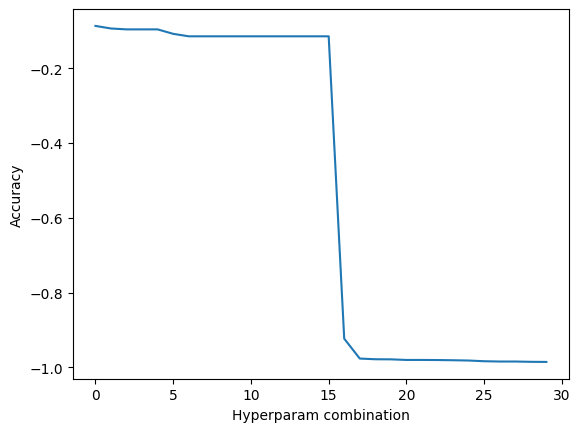

In [24]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

# Evaluate the model

In [25]:
# load best model

model = load_model(path_best_model)

In [26]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 2s 14ms/step - loss: 0.0457 - accuracy: 0.9852


In [27]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.045718494802713394
accuracy 0.9852380752563477


## Confusion matrix

In [28]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 [==============================] - 2s 14ms/step


array([[419,   0,   0,   0,   0,   0,   0,   0,   2,   1],
       [  0, 468,   3,   0,   0,   0,   1,   0,   1,   0],
       [  0,   0, 407,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 421,   0,   1,   0,   1,   1,   1],
       [  0,   0,   1,   0, 414,   0,   3,   3,   4,   4],
       [  0,   0,   0,   0,   0, 378,   3,   0,   1,   0],
       [  0,   0,   0,   0,   2,   0, 409,   0,   1,   0],
       [  0,   3,   9,   1,   0,   0,   0, 456,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0, 382,   0],
       [  0,   0,   0,   0,   3,   0,   0,   1,   6, 384]], dtype=int64)

Text(0.5, 21.34715460257995, 'Predicted label')

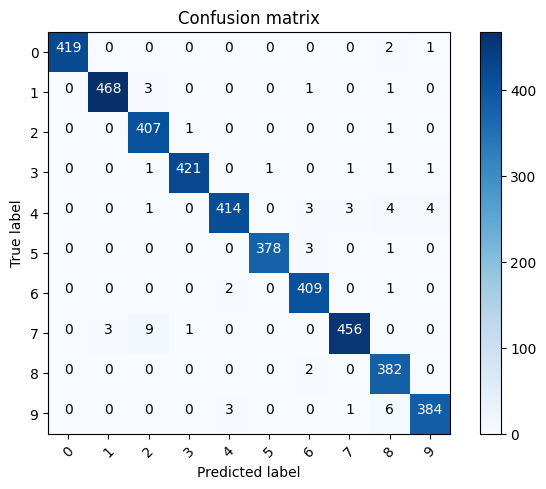

In [29]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.